In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

np.random.seed(2079)

In [16]:
path = '/content/drive/MyDrive/NYU Year 2 S2/ML/meta-learners/'

In [17]:
gotv = pd.read_csv(path+'gotv.csv')

In [18]:
transphobia = pd.read_csv(path+'transphobia.csv')

In [19]:
x_vars = ['sex', 'g2000', 'g2002', 'p2000', 'p2002', 'p2004', 'age']
def data_prep(dataset, x_vars = ['sex', 'g2000', 'g2002', 'p2000', 'p2002', 'p2004', 'age']):
    # Create dataset for voter turnout experiment
    # Y: outcome (here, whether individual i voted or not)
    # W: treatment
    # X: covariates (here, whether individual i voted or not)

    data = pd.DataFrame()
    data['Y'] = dataset['voted'].copy()
    data['W'] = dataset['treatment'].copy()
    data[x_vars] = dataset[x_vars].copy()
    return data

In [20]:
data = data_prep(gotv)
data

,Y,W,sex,g2000,g2002,p2000,p2002,p2004,age
0,0,1,1,1,1,0,1,0,65
1,0,1,0,1,1,0,1,0,59
2,0,0,1,0,0,0,0,0,25
3,1,0,0,1,1,0,1,0,47
4,1,0,1,1,1,0,1,0,50
...,...,...,...,...,...,...,...,...,...
229456,1,0,1,1,1,0,1,1,63
229457,0,0,1,1,1,1,0,1,51
229458,0,0,0,1,0,0,0,0,48
229459,1,0,1,1,1,1,1,1,69


In [21]:
results = pd.read_csv(path+"results.csv")

In [22]:
# Create dataframe with T-, S-, and X-learner CATE
df = data.copy()
df['cate_t'] = results.TRF
df['cate_s'] = results.SRF
df['cate_x'] = results.XRF

In [23]:
df

,Y,W,sex,g2000,g2002,p2000,p2002,p2004,age,cate_t,cate_s,cate_x
0,0,1,1,1,1,0,1,0,65,0.061112,0.047426,0.049350
1,0,1,0,1,1,0,1,0,59,-0.041070,-0.039366,-0.031206
2,0,0,1,0,0,0,0,0,25,-0.030966,-0.028384,-0.037294
3,1,0,0,1,1,0,1,0,47,-0.003935,0.005478,0.006098
4,1,0,1,1,1,0,1,0,50,-0.093262,-0.073857,-0.045063
...,...,...,...,...,...,...,...,...,...,...,...,...
229456,1,0,1,1,1,0,1,1,63,0.023476,0.032024,0.006321
229457,0,0,1,1,1,1,0,1,51,0.047663,0.031286,0.024355
229458,0,0,0,1,0,0,0,0,48,-0.128149,-0.104265,-0.102815
229459,1,0,1,1,1,1,1,1,69,0.089217,0.078073,0.170293



# TODO: 

### * Replicate Figure 3 using RF

Fig. 3.
RMSE, bias, and variance for a simulation based on the social pressure and voter turnout experiment.

Sample training data from the complete data and predict the CATE estimates for the test data using S-, T-, and X-RF. We keep the unequal treatment proportion observed in the full data fixed—i.e., ℙ(W=1)=0.167.

### * Replicate Figure 2, 3 using XGBoost


# Figure 2 

#### Description of Figure 2 from Paper:
Fig. 2 presents the estimated treatment effects, using X-RF where the potential voters are grouped by their voting history. Fig. 2, Upper shows the proportion of voters with a significant positive (blue) and a significant negative (red) CATE estimate. We can see that there is evidence of a negative backlash among a small number of people who voted only once in the past five elections before the general election in 2004. Applied researchers have observed a backlash from these mailers; e.g., some recipients called their Secretary of State’s office or local election registrar to complain (25, 26). Fig. 2, Lower shows the distribution of CATE estimates for each of the subgroups. Having estimates of the heterogeneity enables campaigns to better target the mailers in the future. For example, if the number of mailers is limited, one should target potential voters who voted three times during the past five elections, since this group has the highest ATE and it is a very big group of potential voters.

Fig. 2.
Social pressure and voter turnout. Potential voters are grouped by the number of elections they participated in, ranging from 0 (potential voters who did not vote during the past five elections) to 5 (voters who participated in all five past elections). The width of each group is proportional to the size of the group. (Upper) Positive values correspond to the percentage of voters for which the predicted CATE is significantly positive, while negative values correspond to the percentage of voters for which the predicted CATE is significantly negative. (Lower) The plot shows the CATE estimate distribution for each bin.

In [27]:
def make_fig2(data,cate):
    """
    data: dataset with Y, W, and covariates
    cate: str() either 'x','t',or 's'
    """
    # Create subgroups: count past election participation (ranges from 0 to 5)  
    df['vote_history'] = data['g2000']+data['g2002']+data['p2000']+data['p2002']+data['p2004']
    
    # indicators for individuals for which CATE is negative (positive)
    df[f"cate_{cate}<0"] = 1*(df[f"cate_{cate}"]<0)
    df[f"cate_{cate}>0"] = 1*(df[f"cate_{cate}"]>0)

    # Proportion of voters for which CATE is positive
    df.groupby(by='vote_history',axis=0).mean()[[f"cate_{str(cate)}>0",f"cate_{str(cate)}<0",f"cate_{str(cate)}>0"]]

    
    proportions = df.groupby(by='vote_history',axis=0).agg({f"cate_{cate}>0": ['sum'], 'Y':  ['count']})
 
    # Creating dataset
    est = f"cate_{cate}"

    data_0 = df[df['vote_history'] == 0][est]*100
    data_1 = df[df['vote_history'] == 1][est]*100
    data_2 = df[df['vote_history'] == 2][est]*100
    data_3 = df[df['vote_history'] == 3][est]*100
    data_4 = df[df['vote_history'] == 4][est]*100
    data_5 = df[df['vote_history'] == 5][est]*100
    
    # Each box is based on data for a specific subgroup
    plot_data = [data_0, data_1, data_2, data_3, data_4, data_5]

    # Width is proportional to the size of the group
    subgroup_counts = df.groupby('vote_history').agg({f"cate_{cate}":'count'}).values.flatten()
    width_data = [x/len(df) for x in subgroup_counts]

    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_axes([0, 0, 1, 1])
    plt.grid()
    bp = ax.boxplot(plot_data, widths=width_data,positions=[0,1,2,3,4,5],showfliers=False)

    # Labels
    plt.xlabel('Cumulative Voting History')
    plt.ylabel('CATE')
    plt.title(f"{str.upper(str(cate))}-learner: Figure 2 (Lower) using Honest RF")

    # Format y axis as percentage
    fmt = '%.0f%%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)

    plt.savefig(path+str(cate)+'fig2_lower_BL_HRF')
    plt.show()
    
    return df 


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


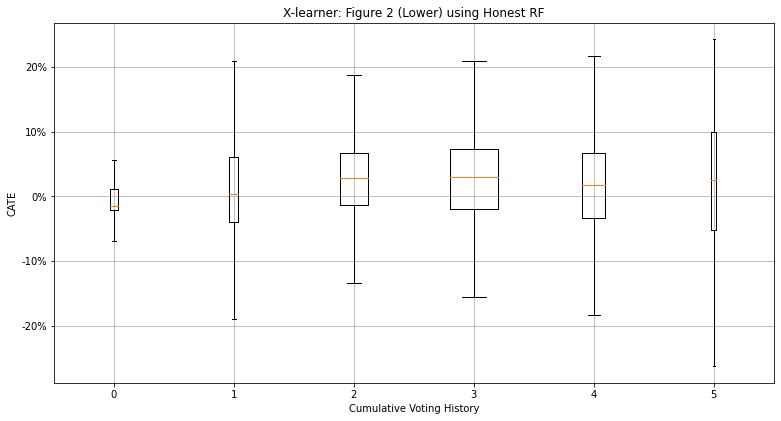

In [28]:
df_cate_x = make_fig2(data=df,cate='x')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


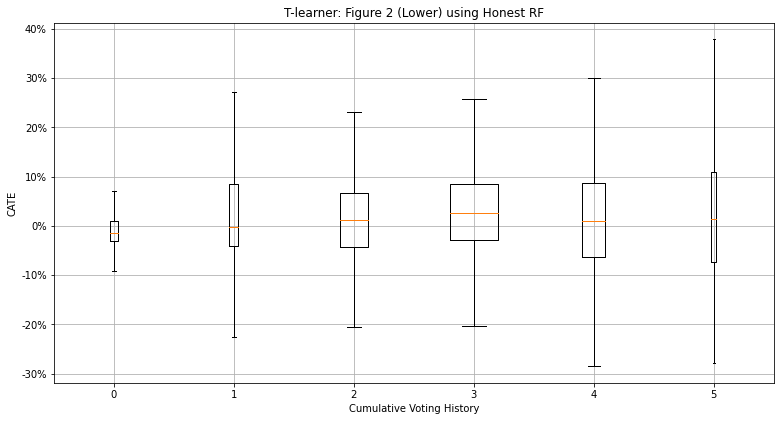

In [29]:
# Create dataframe with T-, S-, and X-learner CATE
df_cate_t = make_fig2(data=df,cate='t')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


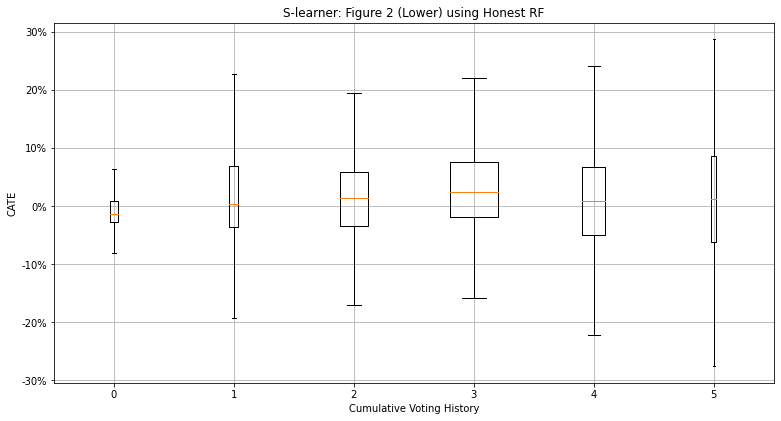

In [30]:
# Create dataframe with T-, S-, and X-learner CATE
df_cate_s = make_fig2(data=df,cate='s')

In [ ]:
# # Estimate the CATE for each subgroup separately (vs. estimate the CATE on whole data and take averages across bins)
# sub0 = df[df['vote_history']==0].copy()
# sub1 = df[df['vote_history']==1].copy()
# sub2 = df[df['vote_history']==2].copy()
# sub3 = df[df['vote_history']==3].copy()
# sub4 = df[df['vote_history']==4].copy()
# sub5 = df[df['vote_history']==5].copy()

# cate_x_sub0 = x_learner(sub0, x_vars, base_learner,base_learner_2=LinearRegression(),prop_classifier=RandomForestClassifier())
# cate_x_sub1 = x_learner(sub1, x_vars, base_learner,base_learner_2=LinearRegression(),prop_classifier=RandomForestClassifier())
# cate_x_sub2 = x_learner(sub2, x_vars, base_learner,base_learner_2=LinearRegression(),prop_classifier=RandomForestClassifier())
# cate_x_sub3 = x_learner(sub3, x_vars, base_learner,base_learner_2=LinearRegression(),prop_classifier=RandomForestClassifier())
# cate_x_sub4 = x_learner(sub4, x_vars, base_learner,base_learner_2=LinearRegression(),prop_classifier=RandomForestClassifier())
# cate_x_sub5 = x_learner(sub5, x_vars, base_learner,base_learner_2=LinearRegression(),prop_classifier=RandomForestClassifier())

In [ ]:
# cate_subgroup = pd.DataFrame(pd.concat((pd.DataFrame(cate_x_sub0),
#                             pd.DataFrame(cate_x_sub1),
#                             pd.DataFrame(cate_x_sub2),
#                             pd.DataFrame(cate_x_sub3),
#                             pd.DataFrame(cate_x_sub4),
#                             pd.DataFrame(cate_x_sub5))))
# cate_subgroup.rename(columns={0:'cate_x_sub'},inplace=True)

In [ ]:
# df_cate_subgroup = cate_subgroup.join(df)
# df_cate_subgroup

In [ ]:
# # indicators for individuals for which CATE is negative (positive)
# df_cate_subgroup['cate_x<0'] = 1*(df_cate_subgroup['cate_x_sub']<0)
# df_cate_subgroup['cate_x>0'] = 1*(df_cate_subgroup['cate_x_sub']>0)

In [ ]:
# # Proportion of voters for which CATE is positive
# df_cate_subgroup.groupby(by='vote_history',axis=0).mean()[['cate_x>0','cate_x<0']]

# TODO: significance levels

Figure 2 (upper) shows percentage of voters for which the predicted CATE is **significantly** positive, while negative values correspond to the percentage of voters for which the predicted CATE is **significantly** negative.

Right now we only have whether CATE is positive or negative, but not whether this is significant or not.

In [ ]:
# # Proportion of voters 
# proportions = df.groupby(by='vote_history',axis=0).agg({'cate_x>0': ['sum'],
#                                                         'Y':  ['count']})


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


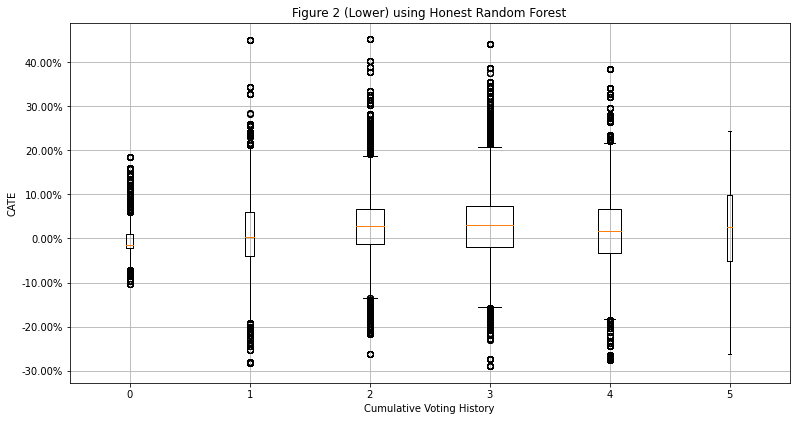

In [32]:
# Creating dataset
cate = 'x'
est = f"cate_{cate}"
# X-learner
df = df_cate_x

data_0 = df[df['vote_history'] == 0][est]*100
data_1 = df[df['vote_history'] == 1][est]*100
data_2 = df[df['vote_history'] == 2][est]*100
data_3 = df[df['vote_history'] == 3][est]*100
data_4 = df[df['vote_history'] == 4][est]*100
data_5 = df[df['vote_history'] == 5][est]*100

# # Creating dataset
# # Use subgroups: replace df by df_cate_subgroup
# data_0 = df_cate_subgroup[df_cate_subgroup['vote_history'] == 0][est]*100
# data_1 = df_cate_subgroup[df_cate_subgroup['vote_history'] == 1][est]*100
# data_2 = df_cate_subgroup[df_cate_subgroup['vote_history'] == 2][est]*100
# data_3 = df_cate_subgroup[df_cate_subgroup['vote_history'] == 3][est]*100
# data_4 = df_cate_subgroup[df_cate_subgroup['vote_history'] == 4][est]*100
# data_5 = df_cate_subgroup[df_cate_subgroup['vote_history'] == 5][est]*100

# Each box is based on data for a specific subgroup
plot_data = [data_0, data_1, data_2, data_3, data_4, data_5]

# Width is proportional to the size of the group
subgroup_counts = df.groupby('vote_history').agg({'cate_x':'count'}).values.flatten()
width_data = [x/len(df) for x in subgroup_counts]

# # Use subgroups: replace df by df_cate_subgroup
# subgroup_counts = df_cate_subgroup.groupby('vote_history').agg({'cate_x':'count'}).values.flatten()
# width_data = [x/len(df_cate_subgroup) for x in subgroup_counts]
  
fig = plt.figure(figsize=(10, 5))
  
ax = fig.add_axes([0, 0, 1, 1])
plt.grid()
bp = ax.boxplot(plot_data, widths=width_data,positions=[0,1,2,3,4,5])

# Labels
plt.xlabel('Cumulative Voting History')
plt.ylabel('CATE')
plt.title(f"Figure 2 (Lower) using Honest Random Forest")

# Format y axis as percentage
fmt = '%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

plt.savefig(path+'fig2_lower_BL_HRF')
plt.show()

In [33]:
df_subgroups = df.groupby('vote_history').agg('mean')
df_subgroups[['cate_x','cate_x<0','cate_x>0']].T

# # Use subgroups: replace df by df_cate_subgroup
# df_subgroups = df_cate_subgroup.groupby('vote_history').agg('mean')*100
# df_subgroups[['cate_x','cate_x<0','cate_x>0']].T

vote_history,0,1,2,3,4,5
cate_x,-0.005372,0.020042,0.029259,0.032688,0.017988,0.019834
cate_x<0,0.718151,0.477106,0.361710,0.320661,0.427251,0.408781
cate_x>0,0.281849,0.522894,0.638290,0.679339,0.572749,0.591219


In [34]:
subgroup_counts

array([14561, 17363, 53717, 90772, 43801,  9247])

In [35]:
df.groupby('vote_history').agg('count')['cate_x>0']

vote_history
0    14561
1    17363
2    53717
3    90772
4    43801
5     9247
Name: cate_x>0, dtype: int64

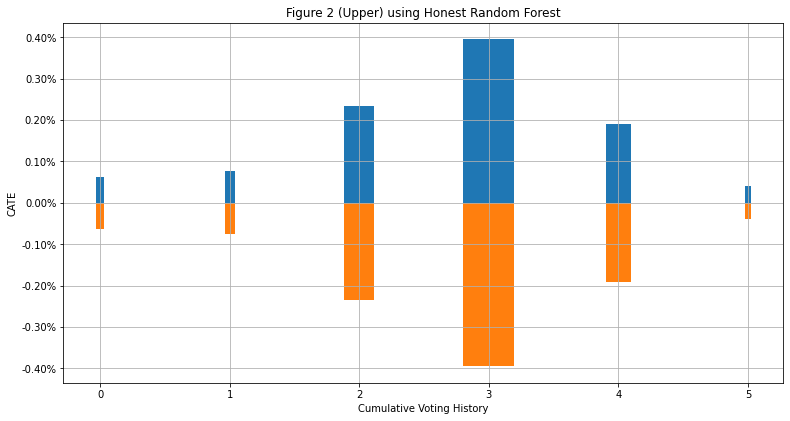

In [36]:
# Creating dataset
var = 'cate_x'

# Width is proportional to the size of the group
df_cate_pos = df.groupby('vote_history').agg('count')['cate_x>0']
df_cate_neg = df.groupby('vote_history').agg('count')['cate_x<0']
subgroup_counts = df.groupby('vote_history').agg({'cate_x':'count'}).values.flatten()
width_data = [x/len(df) for x in subgroup_counts]
x_pos = [0, 1, 2, 3, 4, 5, 6]
  
# # Use subgroups: replace df by df_cate_subgroup
# subgroup_counts = df_cate_subgroup.groupby('vote_history').agg({'cate_x':'count'}).values.flatten()
# width_data = [x/len(df_cate_subgroup) for x in subgroup_counts]

fig = plt.figure(figsize=(10, 5)) 
ax = fig.add_axes([0, 0, 1, 1])
plt.grid()
  
ax.bar(df_cate_pos.index, df_cate_pos/len(df), width=width_data,)
ax.bar(df_cate_neg.index, -df_cate_neg/len(df), width=width_data,)
# ax.bar(df_subgroups.index, df_subgroups['cate_x>0'],width=width_data,)
# ax.bar(df_subgroups.index, -df_subgroups['cate_x<0'],width=width_data,)
# ax.bar(df_subgroups.index, df_subgroups['cate_x'],width=width_data,)
# plt.ylim(-20,110)

# Labels
plt.xlabel('Cumulative Voting History')
plt.ylabel('CATE')
plt.title(f"Figure 2 (Upper) using Honest Random Forest")

# Format y axis as percentage
fmt = '%.2f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
plt.savefig(path+'fig2_upper_BL_HRF')

plt.show()

# Figure 3

We conducted a data-inspired simulation study to see how these estimators would behave in smaller samples. We take the CATE estimates produced by T-RF, and we assume that they are the truth. We can then impute the potential outcomes under both treatment and control for every observation. We then sample training data from the complete data and predict the CATE estimates for the test data using S-, T-, and X-RF. We keep the unequal treatment proportion observed in the full data fixed—i.e., $P(W=1)=0.167$.

# RMSE, bias, variance

### RMSE = $\sqrt{E[(\hat{y}-y)^2]}$

### Bias = $E[\hat{y}]-y$

### Variance = $E[(\hat{y}-E[\hat{y}])^2]$

In [113]:
def compute_rmse(test_cate_t, test_cate_s, test_cate_x, ground_truth):
    # Compute Std. Error for each individual's CATE prediction (ground truth is CATE from T-learner on full data)
    se_t = (test_cate_t - ground_truth)**2
    se_s = (test_cate_s - ground_truth)**2
    se_x = (test_cate_x - ground_truth)**2

    # Return RMSE for each learner
    return np.sqrt(se_t.mean()), np.sqrt(se_s.mean()), np.sqrt(se_x.mean())

In [119]:
def compute_variance(test_cate_t, test_cate_s, test_cate_x, ground_truth):

    # Variance: average of (prediction - average prediction) squared
    sqdev_t = (test_cate_t.mean() - test_cate_t)**2
    sqdev_s = (test_cate_s.mean() - test_cate_s)**2
    sqdev_x = (test_cate_x.mean() - test_cate_x)**2
    var_t = sqdev_t.mean()
    var_s = sqdev_s.mean()
    var_x = sqdev_x.mean()

    # Return average variance for each learner
    return var_t,var_s,var_x

In [117]:
def compute_bias(test_cate_t, test_cate_s, test_cate_x, ground_truth):

    # Bias: how far off the average estimated value is from the true value
    bias_t = (test_cate_t.mean() - ground_truth)
    bias_s = (test_cate_s.mean() - ground_truth)
    bias_x = (test_cate_x.mean() - ground_truth)

    # Return average bias for each learner
    return bias_t.mean(), bias_s.mean(), bias_x.mean()

In [ ]:
#TODO: run a loop on other script to get 8 results{n}.csv with sampled indices for train and rest for test and then loop through them here and start at test cate
# ALSO: add a column with just list of test indices to pick up from results.csv 

In [123]:
training_sizes = [100, 500, 1_000, 2_000, 5_000, 15_000, 40_000, 80_000]
datasets = ["results1.csv","results2.csv","results3.csv","results4.csv","results5.csv","results6.csv","results7.csv","results8.csv"]
# Sample training data from the complete data and predict the CATE estimates for the test data using S-, T-, and X-RF.
rmse_dict = {'t':[],
             's':[],
             'x':[]}
bias_dict = {'t':[],
             's':[],
             'x':[]}
var_dict = {'t':[],
             's':[],
             'x':[]}


for filename in datasets:
    data = pd.read_csv(path + filename)
    test_set = df.loc[list(data.indices-1)]
    test_cate_t = data.TRF
    test_cate_s = data.SRF
    test_cate_x = data.XRF
    # Store RMSE
    rmse_t, rmse_s, rmse_x = compute_rmse(test_cate_t, test_cate_s, test_cate_x, test_set['cate_t'])
    rmse_dict['t'].append(rmse_t)
    rmse_dict['s'].append(rmse_s)
    rmse_dict['x'].append(rmse_x)
    # Store Bias
    avg_bias_t, avg_bias_s, avg_bias_x = compute_bias(test_cate_t, test_cate_s, test_cate_x, test_set['cate_t'])
    bias_dict['t'].append(avg_bias_t)
    bias_dict['s'].append(avg_bias_s)
    bias_dict['x'].append(avg_bias_x)
    # Store Variance
    avg_var_t, avg_var_s, avg_var_x = compute_variance(test_cate_t, test_cate_s, test_cate_x, test_set['cate_t'])
    var_dict['t'].append(avg_var_t)
    var_dict['s'].append(avg_var_s)
    var_dict['x'].append(avg_var_x)


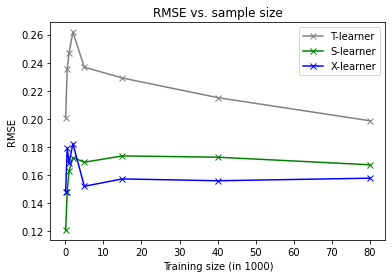

In [125]:
plt.plot([i/1000 for i in training_sizes],rmse_dict['t'],c='gray',marker='x')
plt.plot([i/1000 for i in training_sizes],rmse_dict['s'],c='green',marker='x')
plt.plot([i/1000 for i in training_sizes],rmse_dict['x'],c='blue',marker='x')
plt.title('RMSE vs. sample size')
plt.xlabel('Training size (in 1000)')
plt.ylabel('RMSE')
plt.legend(labels=['T-learner','S-learner','X-learner'])
plt.savefig(path+'fig3_rmse_BL_HRF')
plt.show()

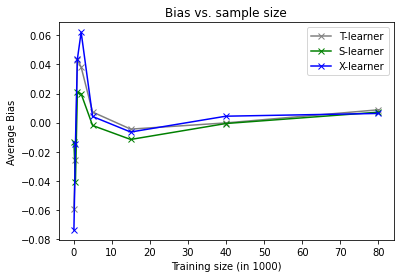

In [128]:
plt.plot([i/1000 for i in training_sizes],bias_dict['t'],c='gray',marker='x')
plt.plot([i/1000 for i in training_sizes],bias_dict['s'],c='green',marker='x')
plt.plot([i/1000 for i in training_sizes],bias_dict['x'],c='blue',marker='x')
plt.title('Bias vs. sample size')
plt.xlabel('Training size (in 1000)')
plt.ylabel('Average Bias')
plt.legend(labels=['T-learner','S-learner','X-learner'])
plt.savefig(path+'fig3_bias_BL_HRF')
plt.show()

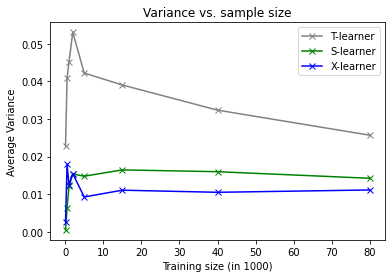

In [129]:
plt.plot([i/1000 for i in training_sizes],var_dict['t'],c='gray',marker='x')
plt.plot([i/1000 for i in training_sizes],var_dict['s'],c='green',marker='x')
plt.plot([i/1000 for i in training_sizes],var_dict['x'],c='blue',marker='x')
plt.title('Variance vs. sample size')
plt.xlabel('Training size (in 1000)')
plt.ylabel('Average Variance')
plt.legend(labels=['T-learner','S-learner','X-learner'])
plt.savefig(path+'fig3_variance_BL_HRF')
plt.show()